In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
# nltk.download('all')

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

import numpy as np
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# model
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### load data

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Academic/Sentiment Analysis/dataset/training/dataset_tweet_sentiment_pilkada_DKI_2017.csv')
dataset = dataset.drop(['Pasangan Calon', 'Id'], axis=1)

alay_dict = pd.read_csv('/content/drive/MyDrive/Academic/New-Sentiment-Analysis/Dataset/hatespeech dataset/new_kamusalay.csv', encoding='latin-1', header=None, names=["Original", "Normalize"] )

In [ ]:
# Kamus alay tambahan
new_entries = [
    {"Original": "rspun", "Normalize": "rumah sakit pun"},
    {"Original": "pitenah", "Normalize": "fitnah"},
    {"Original": "aniessandi", "Normalize": "anies sandi"},
    {"Original": "lap", "Normalize": "usap"},
    {"Original": "calgub", "Normalize": "calon gubernur"},
    {"Original": "dammnn", "Normalize": "damn"},
    {"Original": "golput", "Normalize": "golongan putih"},
    {"Original": "1dan3", "Normalize": "1 dan 3"},
    {"Original": "ksatria", "Normalize": "kesatria"},
    {"Original": "tiada", "Normalize": "tidak ada"},
    {"Original": "joke", "Normalize": "lelucon"},
    {"Original": "hellloooo", "Normalize": "hello"},
    {"Original": "kemrin", "Normalize": "kemarin"},
    {"Original": "aniessandiaga", "Normalize": "anies sandiaga"},
    {"Original": "basukidjarot", "Normalize": "basuki djarot"},
    {"Original": "amieeennnnn", "Normalize": "amin"},
]

# Ubah ke DataFrame
new_entries_df = pd.DataFrame(new_entries)

# Gabungkan dengan DataFrame alay sebelumnya
alay_dict = pd.concat([alay_dict, new_entries_df], ignore_index=True)

# Hapus duplikat jika ada Original yang sama
alay_dict = alay_dict.drop_duplicates(subset='Original', keep='first').reset_index(drop=True)

alay_dict = dict(zip(alay_dict['Original'], alay_dict['Normalize']))

### pre processing data training



In [ ]:
shape = dataset.shape
print(f"Jumlah baris: {shape[0]}")
print(f"Jumlah kolom: {shape[1]}")
dataset.head(10)

Jumlah baris: 900
Jumlah kolom: 2


,Sentiment,Text Tweet
0,negative,Banyak akun kloning seolah2 pendukung #agussil...
1,negative,#agussilvy bicara apa kasihan yaa...lap itu ai...
2,negative,Kalau aku sih gak nunggu hasil akhir QC tp lag...
3,negative,Kasian oh kasian dengan peluru 1milyar untuk t...
4,negative,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...
5,negative,aneh deh lebay masa ini di sangkut pautkan sam...
6,negative,Kepada Allah SWT kami ucapkan rasa syukur dan ...
7,negative,Terima Kasih teruntuk pendukung #AHY #SYLVI ka...
8,negative,Trima Kasih atas KeIstiqomahan Relawan #AHY @A...
9,negative,Mengenang pidato kekalahan #ahy


In [ ]:
print(f"Jumlah duplikasi data di combined_df: {dataset.duplicated().sum()}")

# Menampilkan baris duplikat
duplicate_rows = dataset[dataset.duplicated(keep=False)]
print("\nBaris duplikat:")
duplicate_rows

Jumlah duplikasi data di combined_df: 2

Baris duplikat:


,Sentiment,Text Tweet
36,negative,ahoker masih bully #AHY
126,negative,ahoker masih bully #AHY
625,negative,"Setelah KO di beberapa Polling, kini mereka go..."
738,negative,"Setelah KO di beberapa Polling, kini mereka go..."


In [ ]:
dataset.drop_duplicates(inplace=True)
print(f"jumlah data setelah menghapus duplikasi: {len(dataset )}")

jumlah data setelah menghapus duplikasi: 898


In [ ]:
label_count = dataset['Sentiment'].value_counts()
label_count

,count
Sentiment,
positive,450
negative,448


In [ ]:
import re
import unicodedata

def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'<.*?>', '', text) # Hapus tag seperti <FACE WITH STUCK-OUT TOUNGES>
    return text


def case_folding(text):
    return text.lower()

def normalize_alay(text):
    words = text.split()
    normalized_words = [alay_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

def reduce_repeated_chars(text):
    # Ubah huruf yang berulang lebih dari 2x menjadi maksimal 2 huruf
    return re.sub(r'(.)\1{2,}', r'\1', text)

def remove_non_ascii(text):
    # Menghapus karakter yang bukan ASCII
    return ''.join(c for c in text if ord(c) < 128)


def nontext_clean(text):

    text = remove_non_ascii(text)
    text = re.sub(r'http\S+', ' ', text)           # Ganti URL jadi spasi
    text = re.sub(r'@\w+', ' ', text)             # Ganti mention jadi spasi
    text = re.sub(r'#\w+', ' ', text)             # Ganti hashtag jadi spasi
    text = re.sub(r'[^\w\s]', ' ', text)          # Ganti simbol/punctuation jadi spasi
    text = re.sub(r'\d+', '', text)               # Hapus angka
    text = reduce_repeated_chars(text)            # Normalisasi huruf berulang
    text = re.sub(r'\s+', ' ', text)              # Ganti banyak spasi jadi satu spasi
    text = text.strip()                           # Hapus spasi depan-belakang
    return text



def clean_text(text):
    text = str(text)
    text = remove_non_ascii(text)
    text = remove_emoji(text)
    text = case_folding(text)
    text = nontext_clean(text)
    text = reduce_repeated_chars(text)
    text = normalize_alay(text)
    return text

dataset['cleaned_tweet'] = dataset['Text Tweet'].apply(clean_text)

In [ ]:
print(f"jumlah data setelah menghapus data kosong: {len(dataset )}")
dataset

jumlah data setelah menghapus data kosong: 898


,Sentiment,Text Tweet,cleaned_tweet
0,negative,Banyak akun kloning seolah2 pendukung #agussil...,banyak akun kloning seolah pendukung mulai men...
1,negative,#agussilvy bicara apa kasihan yaa...lap itu ai...,bicara apa kasihan ya usap itu air matanya wkwk
2,negative,Kalau aku sih gak nunggu hasil akhir QC tp lag...,kalau aku sih tidak menunggu hasil akhir qc te...
3,negative,Kasian oh kasian dengan peluru 1milyar untuk t...,kasihan oh kasihan dengan peluru milyar untuk ...
4,negative,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya pendukung hayo dukung diputaran
...,...,...,...
895,positive,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ...",kali saja bapak lihat lagi di rumah sakit pun ...
896,positive,Kita harus dapat merangkul semua orang tanpa b...,kita harus dapat merangkul semua orang tanpa b...
897,positive,Ini jagoanku dibidang digital <Smiling Face Wi...,ini jagoanku dibidang digital
898,positive,#PesanBijak #OkeOce #GubernurGu3 ...,


In [ ]:
# Hapus baris yang cleaned_tweet-nya kosong atau hanya berisi spasi
dataset = dataset[dataset['cleaned_tweet'].str.strip() != '']

dataset

,Sentiment,Text Tweet,cleaned_tweet
0,negative,Banyak akun kloning seolah2 pendukung #agussil...,banyak akun kloning seolah pendukung mulai men...
1,negative,#agussilvy bicara apa kasihan yaa...lap itu ai...,bicara apa kasihan ya usap itu air matanya wkwk
2,negative,Kalau aku sih gak nunggu hasil akhir QC tp lag...,kalau aku sih tidak menunggu hasil akhir qc te...
3,negative,Kasian oh kasian dengan peluru 1milyar untuk t...,kasihan oh kasihan dengan peluru milyar untuk ...
4,negative,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya pendukung hayo dukung diputaran
...,...,...,...
894,positive,"Ingat, pilih no.3 di tanggal 19 April nanti ya...",ingat pilih no di tanggal april nanti ya kakak
895,positive,"Kali saja bpk @aniesbaswedan @sandiuno lihat, ...",kali saja bapak lihat lagi di rumah sakit pun ...
896,positive,Kita harus dapat merangkul semua orang tanpa b...,kita harus dapat merangkul semua orang tanpa b...
897,positive,Ini jagoanku dibidang digital <Smiling Face Wi...,ini jagoanku dibidang digital


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
dataset['encoded_sentiment'] = label_encoder.fit_transform(dataset['Sentiment'])
dataset.drop('Sentiment', axis=1, inplace=True)

/tmp/ipython-input-14-2947706004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['encoded_sentiment'] = label_encoder.fit_transform(dataset['Sentiment'])
/tmp/ipython-input-14-2947706004.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop('Sentiment', axis=1, inplace=True)


In [ ]:
dataset.sample(10)

,Text Tweet,cleaned_tweet,encoded_sentiment
264,"Dengan kecerdasan, nasionalisme dan jiwa panca...",dengan kecerdasan nasionalisme dan jiwa pancas...,1
417,Dulu mereka bilang #AHY cagub #FPI sekarang #A...,dulu mereka bilang calon gubernur sekarang cal...,0
13,aku juga kemarin #AHY 19april2017 suaraku utk ...,aku juga kemarin april suaraku untuk pasangan ...,0
195,Mari beri masukan & kritik yang membangun bagi...,mari beri masukan kritik yang membangun bagi y...,1
110,Mau nyoblos atau mau ke tempat berkabung. <Ton...,mau mencoblos atau mau ke tempat berkabung mem...,0
462,"Tidak apa-apa Ahok kalah, supaya sedikit aman....",tidak apa apa ahok kalah supaya sedikit aman c...,1
661,"#AniesSandi mampu beretorika sangat indah, DP0...",mampu beretorika sangat indah uang muka ternya...,0
755,Selamat untuk Pasangan No. 3 Anies- Sandi. #pi...,selamat untuk pasangan no anies sandi mari kit...,1
243,bu Sylvi adalah contoh keberanian betawi utk d...,bu sylvi adalah contoh keberanian betawi untuk...,1
71,"Ketika AHY kalah & berpidato, semua timnya ter...",ketika agus harimurti yudhoyono kalah berpidat...,0


Tokenization

In [ ]:
def tokenize_text(kalimat):
    tokens = nltk.tokenize.word_tokenize(kalimat)
    return tokens

In [ ]:
dataset['token'] = dataset['cleaned_tweet'].apply(tokenize_text)
dataset.head()

/tmp/ipython-input-17-3671867107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['token'] = dataset['cleaned_tweet'].apply(tokenize_text)


,Text Tweet,cleaned_tweet,encoded_sentiment,token
0,Banyak akun kloning seolah2 pendukung #agussil...,banyak akun kloning seolah pendukung mulai men...,0,"[banyak, akun, kloning, seolah, pendukung, mul..."
1,#agussilvy bicara apa kasihan yaa...lap itu ai...,bicara apa kasihan ya usap itu air matanya wkwk,0,"[bicara, apa, kasihan, ya, usap, itu, air, mat..."
2,Kalau aku sih gak nunggu hasil akhir QC tp lag...,kalau aku sih tidak menunggu hasil akhir qc te...,0,"[kalau, aku, sih, tidak, menunggu, hasil, akhi..."
3,Kasian oh kasian dengan peluru 1milyar untuk t...,kasihan oh kasihan dengan peluru milyar untuk ...,0,"[kasihan, oh, kasihan, dengan, peluru, milyar,..."
4,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya pendukung hayo dukung diputaran,0,"[maaf, ya, pendukung, hayo, dukung, diputaran]"


Filtering (stopwords)

In [ ]:
stopword = set(stopwords.words('indonesian'))

def stopwords_text(tokens):
    cleaned_tokens = []
    for token in tokens:
        if token.lower() not in stopword:
            cleaned_tokens.append(token)
    return cleaned_tokens

In [ ]:
dataset['stop'] = dataset['token'].apply(stopwords_text)

/tmp/ipython-input-19-4098588274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['stop'] = dataset['token'].apply(stopwords_text)


Stemming

In [ ]:
stem_factory = StemmerFactory()
stemmer = stem_factory.create_stemmer()

def stemming_text(tokens):
  hasil = [stemmer.stem(token) for token in tokens]
  return hasil

In [ ]:
dataset['stem'] = dataset['stop'].apply(stemming_text)
dataset.head()

/tmp/ipython-input-21-407418605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['stem'] = dataset['stop'].apply(stemming_text)


,Text Tweet,cleaned_tweet,encoded_sentiment,token,stop,stem
0,Banyak akun kloning seolah2 pendukung #agussil...,banyak akun kloning seolah pendukung mulai men...,0,"[banyak, akun, kloning, seolah, pendukung, mul...","[akun, kloning, pendukung, menyerang, pasangan...","[akun, kloning, dukung, serang, pasang, calon,..."
1,#agussilvy bicara apa kasihan yaa...lap itu ai...,bicara apa kasihan ya usap itu air matanya wkwk,0,"[bicara, apa, kasihan, ya, usap, itu, air, mat...","[bicara, kasihan, ya, usap, air, matanya, wkwk]","[bicara, kasihan, ya, usap, air, mata, wkwk]"
2,Kalau aku sih gak nunggu hasil akhir QC tp lag...,kalau aku sih tidak menunggu hasil akhir qc te...,0,"[kalau, aku, sih, tidak, menunggu, hasil, akhi...","[sih, menunggu, hasil, qc, menunggu, motif, cu...","[sih, tunggu, hasil, qc, tunggu, motif, cuit, ..."
3,Kasian oh kasian dengan peluru 1milyar untuk t...,kasihan oh kasihan dengan peluru milyar untuk ...,0,"[kasihan, oh, kasihan, dengan, peluru, milyar,...","[kasihan, oh, kasihan, peluru, milyar, rukun, ...","[kasihan, oh, kasihan, peluru, milyar, rukun, ..."
4,Maaf ya pendukung #AgusSilvy..hayo dukung #Ani...,maaf ya pendukung hayo dukung diputaran,0,"[maaf, ya, pendukung, hayo, dukung, diputaran]","[maaf, ya, pendukung, hayo, dukung, diputaran]","[maaf, ya, dukung, hayo, dukung, putar]"


In [ ]:
dataset[['stem', 'encoded_sentiment']].to_csv('text-preprocessing.csv', index=False)

### TF-IDF

In [ ]:
clean_data = pd.read_csv('text-preprocessing.csv')
clean_data = clean_data.rename(columns={'stem': 'tweet', "encoded_sentiment": "sentiment"})
clean_data

,tweet,sentiment
0,"['akun', 'kloning', 'dukung', 'serang', 'pasan...",0
1,"['bicara', 'kasihan', 'ya', 'usap', 'air', 'ma...",0
2,"['sih', 'tunggu', 'hasil', 'qc', 'tunggu', 'mo...",0
3,"['kasihan', 'oh', 'kasihan', 'peluru', 'milyar...",0
4,"['maaf', 'ya', 'dukung', 'hayo', 'dukung', 'pu...",0
...,...,...
877,"['pilih', 'no', 'tanggal', 'april', 'ya', 'kak...",1
878,"['kali', 'lihat', 'rumah', 'sakit', 'swafoto']",1
879,"['rangkul', 'orang', 'batas', 'usia', 'kelamin']",1
880,"['jago', 'bidang', 'digital']",1


In [ ]:
import ast
clean_data['tweet_joined'] = clean_data['tweet'].apply(lambda x: " ".join(ast.literal_eval(x)))

In [ ]:
clean_data

,tweet,sentiment,tweet_joined
0,"['akun', 'kloning', 'dukung', 'serang', 'pasan...",0,akun kloning dukung serang pasang calon opini ...
1,"['bicara', 'kasihan', 'ya', 'usap', 'air', 'ma...",0,bicara kasihan ya usap air mata wkwk
2,"['sih', 'tunggu', 'hasil', 'qc', 'tunggu', 'mo...",0,sih tunggu hasil qc tunggu motif cuit kayak pa...
3,"['kasihan', 'oh', 'kasihan', 'peluru', 'milyar...",0,kasihan oh kasihan peluru milyar rukun warga m...
4,"['maaf', 'ya', 'dukung', 'hayo', 'dukung', 'pu...",0,maaf ya dukung hayo dukung putar
...,...,...,...
877,"['pilih', 'no', 'tanggal', 'april', 'ya', 'kak...",1,pilih no tanggal april ya kakak
878,"['kali', 'lihat', 'rumah', 'sakit', 'swafoto']",1,kali lihat rumah sakit swafoto
879,"['rangkul', 'orang', 'batas', 'usia', 'kelamin']",1,rangkul orang batas usia kelamin
880,"['jago', 'bidang', 'digital']",1,jago bidang digital


In [ ]:
# TF-IDF settings
tf_idf = TfidfVectorizer(ngram_range=(1,3))

### Modeling

In [ ]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"\n Evaluation: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
#  Train MultinomialNB
x = tf_idf.fit_transform(clean_data['tweet_joined'])
y = clean_data['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True)
model = MultinomialNB()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)


 Evaluation: MultinomialNB
Accuracy: 0.6629213483146067
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.52      0.62        48
           1       0.60      0.83      0.69        41

    accuracy                           0.66        89
   macro avg       0.69      0.68      0.66        89
weighted avg       0.70      0.66      0.66        89



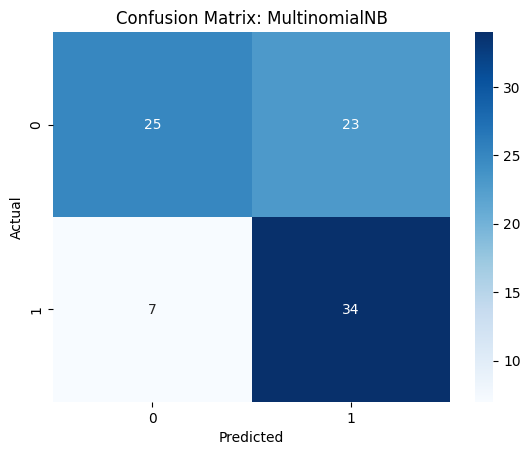

In [ ]:
# Run Evaluations
# evaluate_model("BernoulliNB", yb_test, yb_pred)
evaluate_model("MultinomialNB", y_test, y_pred)

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3))),
    ('clf', MultinomialNB(alpha=0.5))
])


📂 Fold 1

 Evaluation: MultinomialNB - Fold 1
Accuracy: 0.6756756756756757
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67        38
           1       0.65      0.72      0.68        36

    accuracy                           0.68        74
   macro avg       0.68      0.68      0.68        74
weighted avg       0.68      0.68      0.68        74



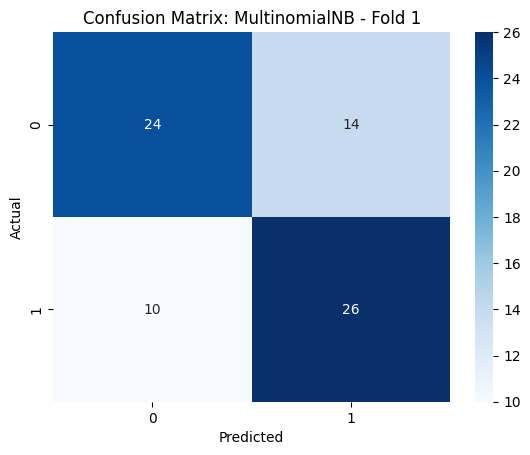


📂 Fold 2

 Evaluation: MultinomialNB - Fold 2
Accuracy: 0.6891891891891891
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.63      0.68        38
           1       0.66      0.75      0.70        36

    accuracy                           0.69        74
   macro avg       0.69      0.69      0.69        74
weighted avg       0.69      0.69      0.69        74



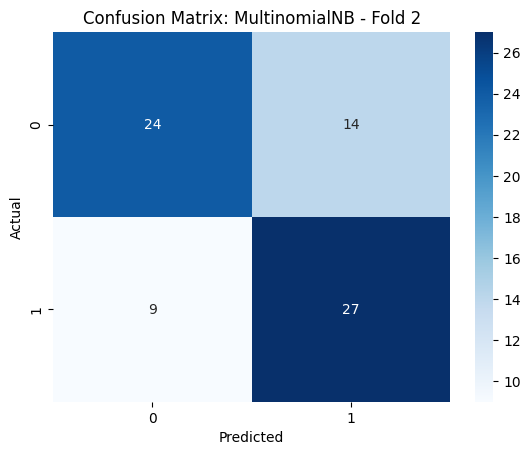


📂 Fold 3

 Evaluation: MultinomialNB - Fold 3
Accuracy: 0.6216216216216216
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.51      0.58        37
           1       0.60      0.73      0.66        37

    accuracy                           0.62        74
   macro avg       0.63      0.62      0.62        74
weighted avg       0.63      0.62      0.62        74



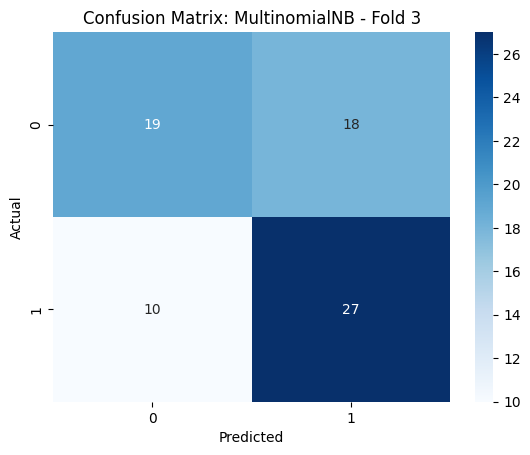


📂 Fold 4

 Evaluation: MultinomialNB - Fold 4
Accuracy: 0.6351351351351351
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.57      0.61        37
           1       0.62      0.70      0.66        37

    accuracy                           0.64        74
   macro avg       0.64      0.64      0.63        74
weighted avg       0.64      0.64      0.63        74



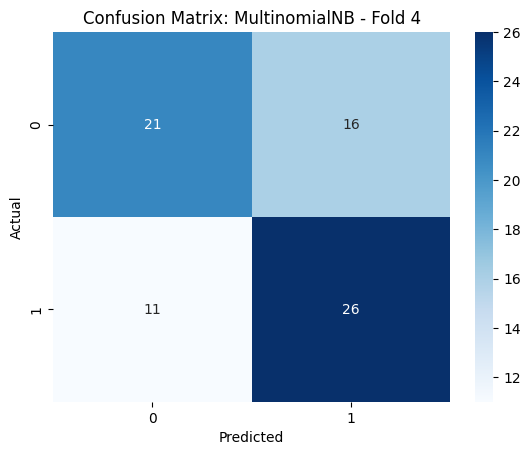


📂 Fold 5

 Evaluation: MultinomialNB - Fold 5
Accuracy: 0.7297297297297297
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.70      0.72        37
           1       0.72      0.76      0.74        37

    accuracy                           0.73        74
   macro avg       0.73      0.73      0.73        74
weighted avg       0.73      0.73      0.73        74



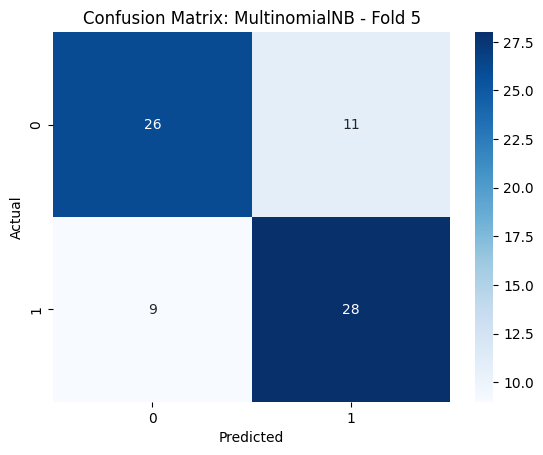


📂 Fold 6

 Evaluation: MultinomialNB - Fold 6
Accuracy: 0.6756756756756757
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.59      0.65        37
           1       0.65      0.76      0.70        37

    accuracy                           0.68        74
   macro avg       0.68      0.68      0.67        74
weighted avg       0.68      0.68      0.67        74



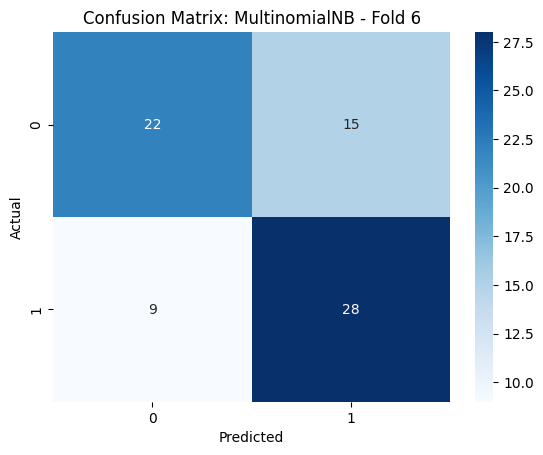


📂 Fold 7

 Evaluation: MultinomialNB - Fold 7
Accuracy: 0.7123287671232876
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70        37
           1       0.68      0.78      0.73        36

    accuracy                           0.71        73
   macro avg       0.72      0.71      0.71        73
weighted avg       0.72      0.71      0.71        73



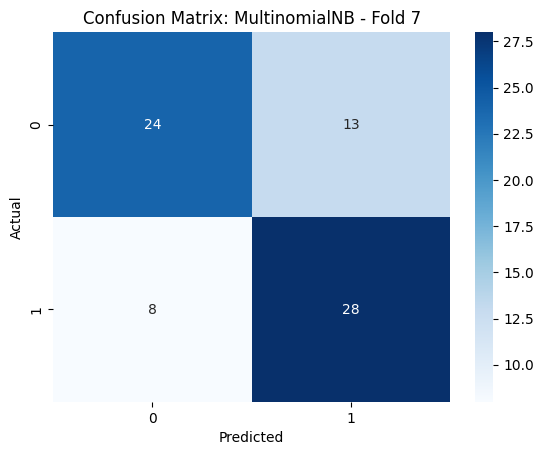


📂 Fold 8

 Evaluation: MultinomialNB - Fold 8
Accuracy: 0.589041095890411
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.57      0.58        37
           1       0.58      0.61      0.59        36

    accuracy                           0.59        73
   macro avg       0.59      0.59      0.59        73
weighted avg       0.59      0.59      0.59        73



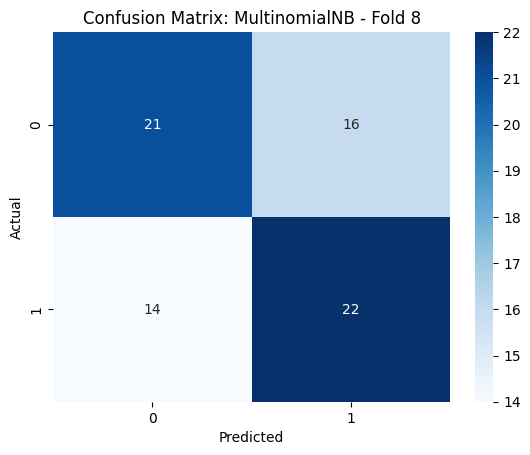


📂 Fold 9

 Evaluation: MultinomialNB - Fold 9
Accuracy: 0.726027397260274
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.62      0.70        37
           1       0.68      0.83      0.75        36

    accuracy                           0.73        73
   macro avg       0.74      0.73      0.72        73
weighted avg       0.74      0.73      0.72        73



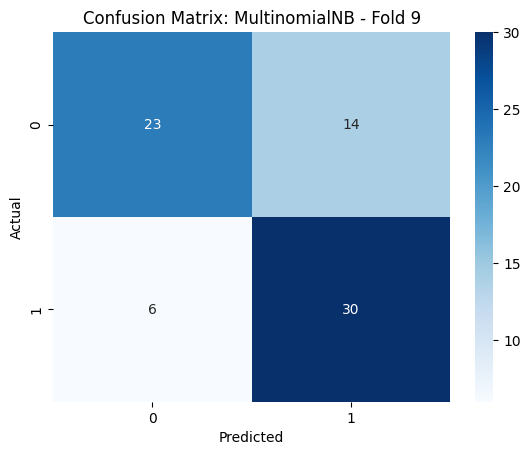


📂 Fold 10

 Evaluation: MultinomialNB - Fold 10
Accuracy: 0.7123287671232876
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.65      0.70        37
           1       0.68      0.78      0.73        36

    accuracy                           0.71        73
   macro avg       0.72      0.71      0.71        73
weighted avg       0.72      0.71      0.71        73



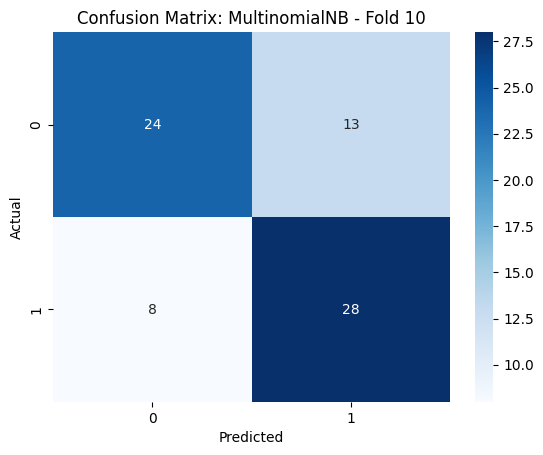


📂 Fold 11

 Evaluation: MultinomialNB - Fold 11
Accuracy: 0.684931506849315
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.65      0.68        37
           1       0.67      0.72      0.69        36

    accuracy                           0.68        73
   macro avg       0.69      0.69      0.68        73
weighted avg       0.69      0.68      0.68        73



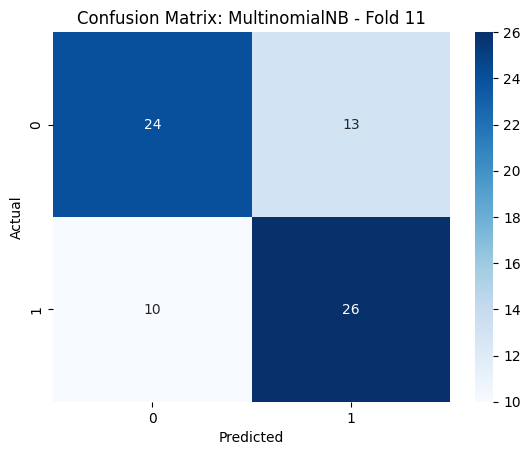


📂 Fold 12

 Evaluation: MultinomialNB - Fold 12
Accuracy: 0.7534246575342466
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76        37
           1       0.76      0.72      0.74        36

    accuracy                           0.75        73
   macro avg       0.75      0.75      0.75        73
weighted avg       0.75      0.75      0.75        73



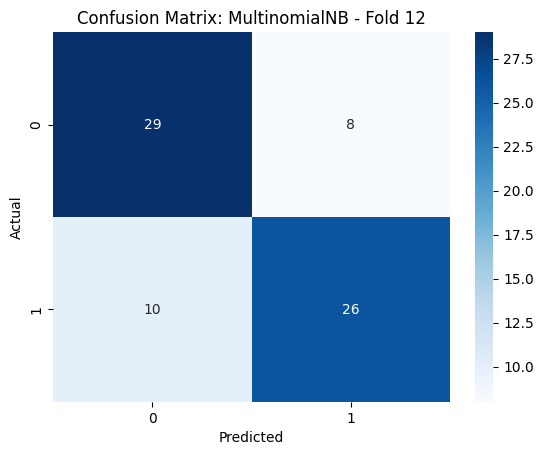


📊 Average Accuracy across folds: 0.6837591015673209


In [ ]:
from sklearn.model_selection import StratifiedKFold

#  Train MultinomialNB

x = clean_data['tweet_joined']
y = clean_data['sentiment']

# Set up K-Fold
kf = StratifiedKFold(n_splits=12, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_index, test_index in kf.split(x, y):
    # Split the text and labels
    x_train_text, x_test_text = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # TF-IDF transformation
    # x_train = tf_idf.fit_transform(x_train_text)
    # x_test = tf_idf.transform(x_test_text)

    # # Train model
    # model = MultinomialNB(alpha = 0.5)
    # model.fit(x_train, y_train)

    pipeline.fit(x_train_text, y_train)


    # Predict and evaluate
    y_pred = pipeline.predict(x_test_text)
    print(f"\n📂 Fold {fold}")
    evaluate_model(f"MultinomialNB - Fold {fold}", y_test, y_pred)

    # Save accuracy
    accuracies.append(accuracy_score(y_test, y_pred))
    fold += 1

# Summary
print("\n📊 Average Accuracy across folds:", sum(accuracies) / len(accuracies))

In [ ]:
import joblib

# Simpan model
joblib.dump(pipeline, 'sentiment_pipeline.pkl')

['sentiment_pipeline.pkl']